<b>Data mining project - 2020/21</b><br>
<b>Author</b>: [Alexandra Bradan](https://github.com/alexandrabradan)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 07/01/2021<b>

In [135]:
%matplotlib inline

# general libraries
import sys
import math
import operator
import itertools
import pydotplus
import collections
import missingno as msno
from pylab import MaxNLocator
from collections import Counter
from collections import defaultdict
from IPython.display import Image

# pandas libraries
import pandas as pd
from pandas import DataFrame
from pandas.testing import assert_frame_equal

# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

# numpy libraries
import numpy as np
from numpy import std
from numpy import mean
from numpy import arange
from numpy import unique
from numpy import percentile

# scipy libraries
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import normaltest

# sklearn libraries
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer  # explicitly require this experimental feature
from sklearn.impute import IterativeImputer

from sklearn import tree
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.pipeline import make_pipeline as imbmake_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, recall_score, precision_score, classification_report, roc_auc_score 

In [136]:
data_directory = "../../../data/"
plot_directory = "../../../plots/DataUnderstanding/"
TR_file = data_directory + "Train_HR_Employee_Attrition.csv"
TR_cleaned_file = data_directory + "Cleaned_Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "One_Hot_Encoding_Test_HR_Employee_Attrition.csv"

In [137]:
df_cleaned = pd.read_csv(TR_cleaned_file, sep=",") 
df_ts = pd.read_csv(TS_file, sep=",") 

In [138]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     883 non-null    int64  
 1   Attrition                               883 non-null    int64  
 2   BusinessTravel_Non-Travel               883 non-null    int64  
 3   BusinessTravel_Travel_Rarely            883 non-null    int64  
 4   BusinessTravel_Travel_Frequently        883 non-null    int64  
 5   DistanceFromHome                        883 non-null    int64  
 6   Education                               883 non-null    int64  
 7   EnvironmentSatisfaction                 883 non-null    int64  
 8   Gender                                  883 non-null    int64  
 9   JobInvolvement                          883 non-null    int64  
 10  JobLevel                                883 non-null    int64 

In [139]:
print(df_cleaned.shape)
print(df_ts.shape)

(883, 36)
(219, 37)


<h2> Discretisation approach </h2> 
Approaches to transform continuous variables into discrete ones. This process is also known as <b>binning</b>, with each bin being each interval. Discretization methods fall into 2 categories: 

- supervised: do not use any information, other than the variable distribution, to create the contiguous bins in which the values will be placed;
- unsupervised: typically use target information in order to create bins or intervals.

Since we are dealying with DT it is natural to use a **supervised discretisation method** with them:

<u>Step 1</u>: First it trains a decision tree of limited depth (2, 3 or 4) using the variable we want to discretize to predict the target;

<u>Step 2</u>: The original variable values are then replaced by the probability returned by the tree. The probability is the same for all the observations within a single bin, thus replacing by the probability is equivalent to grouping the observations within the cut-off decided by the decision tree.

**Advantages** :
- The probabilistic predictions returned decision tree are monotonically related to the target.
- The new bins show decreased entropy, this is the observations within each bucket/bin are more similar to themselves than to those of other buckets/bins.
- The tree finds the bins automatically.

**Disadvantages**:
- It may cause over-fitting
- More importantly, some tuning of tree parameters might need to be done to obtain the optimal splits (e.g., depth, the minimum number of samples in one partition, the maximum number of partitions, and a minimum information gain). This it can be time-consuming.

<u>Features to discretize</u>:
- Age
- DistanceFromHome
- YearsAtCompany
- YearsInCurrentRole
- NumCompaniesWorked
- MonthlyIncome
- MonthlyHours

- PercentSalaryHike
- TaxRate

<h2> Training discretisation </h2>

In [140]:
X_train = df_cleaned.copy()
y_train = df_cleaned['Attrition']

In [141]:
def select_optimal_tree_depth(tree_model, variable):
    # selecting the optimal depth of the tree
    score_ls = []     # here I will store the roc auc
    score_std_ls = [] # here I will store the standard deviation of the roc_auc
    for tree_depth in range(1, 4):
        tree_model = DecisionTreeClassifier(max_depth=tree_depth)

        scores = cross_val_score(tree_model, X_train[[variable]], y_train, cv=3, scoring='roc_auc')   
        score_ls.append(np.mean(scores))
        score_std_ls.append(np.std(scores))

    temp = pd.concat([pd.Series(list(range(1, 4))), pd.Series(score_ls), pd.Series(score_std_ls)], axis=1)
    temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
    # print(temp)
    max_i = temp["roc_auc_mean"].max()
    optimal_depth = temp[temp["roc_auc_mean"] == max_i]["depth"].item()
    return optimal_depth

In [142]:
pd.options.mode.chained_assignment = None  # default='warn'
def variable_discretisation_insight(variable):
    # arbitrary initialisation with max_depth=2
    tree_model = DecisionTreeClassifier(max_depth=2)
    # usinge variable to predict Attrition
    tree_model.fit(X_train[[variable]], X_train.Attrition)  
    # creating new variable which contains the probability of a record belonging to the corresponding class
    new_variable = '%s_tree' % variable
    # print(tree_model.predict_proba(X_train[[variable]])[:,1].shape)
    # X_train.loc[new_variable] = tree_model.predict_proba(X_train[[variable]])[:,1] 
    
    optimal_depth = select_optimal_tree_depth(tree_model, variable)
    print("%s's optimal_depth=%d" % (variable, optimal_depth))
    tree_model = DecisionTreeClassifier(max_depth=optimal_depth)
    # usinge Age to predict Attrition
    tree_model.fit(X_train[[variable]], X_train.Attrition)  
    # creating new variable which contains the probability of a record belonging to the corresponding class
    X_train[new_variable] = tree_model.predict_proba(X_train[[variable]])[:,1]
    
    # discretisation insight
    # ex. a tree of depth 2, makes 2 splits, therefore generating 4 buckets
    print(X_train[new_variable].unique())

    # check the relationship between the discretized new variable and the target Attrition
    fig = plt.figure()
    fig = X_train.groupby([new_variable])['Attrition'].mean().plot()
    fig.set_title('Monotonic relationship between discretised %s and target' % new_variable)
    fig.set_ylabel('Attrition')
    plt.show()

    # checking the number of passengers per probabilistic bucket/bin to under the distribution of 
    # the discretized variable
    X_train.groupby([new_variable])['Attrition'].count().plot.bar()
    plt.show()

    # checking Age limit buckets generated by the tree
    df_bin = pd.concat( [X_train.groupby([new_variable])[variable].min(),
                X_train.groupby([new_variable])[variable].max()], axis=1)
    print(df_bin)
    return df_bin

In [143]:
def discretize_test_set_variable(variable_name, bins_mapping):
    new_data = []
    data = df_ts[[variable_name]]
    column_index = df_ts.columns.get_loc(variable_name)
    for i in range(0, len(data)):
        val = df_ts.iloc[i, column_index]
        prev_len = len(new_data)
        for key, value in bins_mapping.items():
            if val >= value["left"] and val <= value["right"]:
                new_data.append(float(key))
                break
        succ_len = len(new_data)
        if prev_len == succ_len:
            if variable_name == "MonthlyIncome":
                if val == 4115:
                    new_data.append(0.143731)
                elif val == 9148:
                    new_data.append(0.358491)
                elif val == 4108:
                    new_data.append(0.143731)
                elif val == 4508:
                    new_data.append(0.213333)
                else:
                    print(val)
            else:
                last_elem = float(list(bins_mapping.keys())[-1])
                new_data.append(last_elem)
    df_ts[variable_name] = new_data
    return df_ts

<h6>Age </h6>
Build a classification tree using the Age to predict Attrition in order to discretise the age variable

Age's optimal_depth=1
[0.17159091 0.66666667]


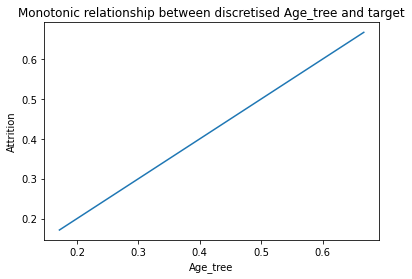

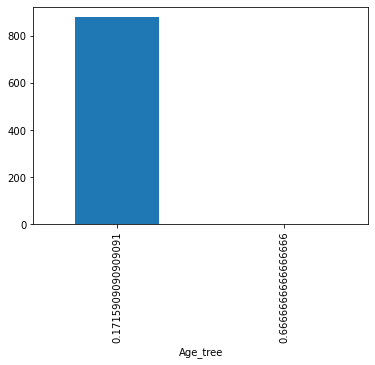

          Age  Age
Age_tree          
0.171591   18   59
0.666667   60   60
{'0.1715909090909091': {'left': 18, 'right': 59}, '0.6666666666666666': {'left': 60, 'right': 60}}


In [144]:
df_bin = variable_discretisation_insight("Age")
bins_mapping = {}
bins_list = list(df_bin.index)
for row, i in zip(df_bin.itertuples(), range(0, len(bins_list))):
    left = row.Age
    right = row._2
    bins_mapping[str(bins_list[i])] = {}
    bins_mapping[str(bins_list[i])]["left"] = left
    bins_mapping[str(bins_list[i])]["right"] = right
print(bins_mapping)
df_ts = discretize_test_set_variable("Age" , bins_mapping)

Age is NOT a discretisation candidate

<h6>DistanceFromHome </h6>
Build a classification tree using the variable to predict Attrition in order to discretise it

DistanceFromHome's optimal_depth=1
[0.20980926 0.14728682]


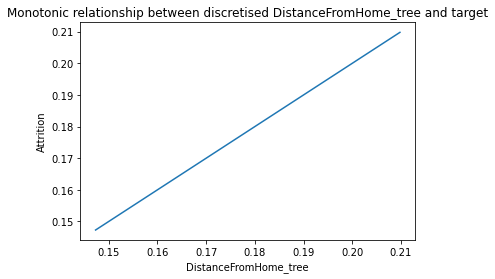

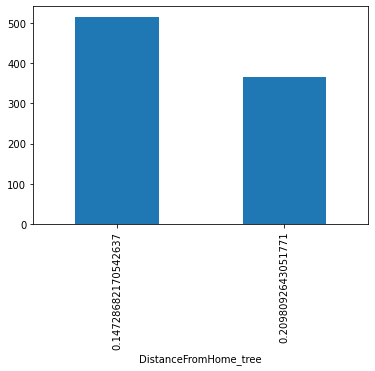

                       DistanceFromHome  DistanceFromHome
DistanceFromHome_tree                                    
0.147287                              1                 8
0.209809                              9                29
{'0.14728682170542637': {'left': 1, 'right': 8}, '0.2098092643051771': {'left': 9, 'right': 29}}


In [145]:
df_bin = variable_discretisation_insight("DistanceFromHome")
bins_mapping = {}
bins_list = list(df_bin.index)
for row, i in zip(df_bin.itertuples(), range(0, len(bins_list))):
    left = row.DistanceFromHome
    right = row._2
    bins_mapping[str(bins_list[i])] = {}
    bins_mapping[str(bins_list[i])]["left"] = left
    bins_mapping[str(bins_list[i])]["right"] = right
print(bins_mapping)
df_ts = discretize_test_set_variable("DistanceFromHome" , bins_mapping)

Distance is a discretisation candidate

<h6> YearsAtCompany </h6>

In [146]:
to_drop_indexes = df_ts.index[df_ts["YearsAtCompany"] > 20]
df_ts.drop(list(to_drop_indexes), axis=0, inplace=True)
df_ts.reset_index(drop=True, inplace=True)
print("dropped rows = ", len(to_drop_indexes), sep="\t")

df_ts.shape

dropped rows = 	0


(219, 37)

YearsAtCompany's optimal_depth=1
[0.21983914 0.13921569]


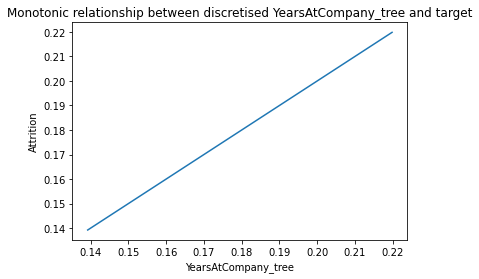

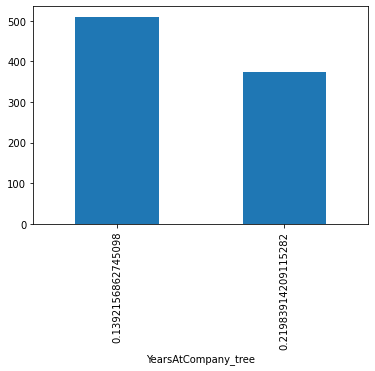

                     YearsAtCompany  YearsAtCompany
YearsAtCompany_tree                                
0.139216                          0               6
0.219839                          7              20
{'0.1392156862745098': {'left': 0, 'right': 6}, '0.21983914209115282': {'left': 7, 'right': 20}}


In [147]:
df_bin = variable_discretisation_insight("YearsAtCompany")
bins_mapping = {}
bins_list = list(df_bin.index)
for row, i in zip(df_bin.itertuples(), range(0, len(bins_list))):
    left = row.YearsAtCompany
    right = row._2
    bins_mapping[str(bins_list[i])] = {}
    bins_mapping[str(bins_list[i])]["left"] = left
    bins_mapping[str(bins_list[i])]["right"] = right
print(bins_mapping)
df_ts = discretize_test_set_variable("YearsAtCompany" , bins_mapping)

YearsAtCompany is a discretisation candidate

<h6> YearsInCurrentRole </h6>

In [148]:
to_drop_indexes = df_ts.index[df_ts["YearsInCurrentRole"] > 16]
df_ts.drop(list(to_drop_indexes), axis=0, inplace=True)
df_ts.reset_index(drop=True, inplace=True)
print("dropped rows = ", len(to_drop_indexes), sep="\t")

df_ts.shape

dropped rows = 	0


(219, 37)

YearsInCurrentRole's optimal_depth=3
[0.08759124 0.         0.18032787 0.15584416 0.33333333 0.27777778]


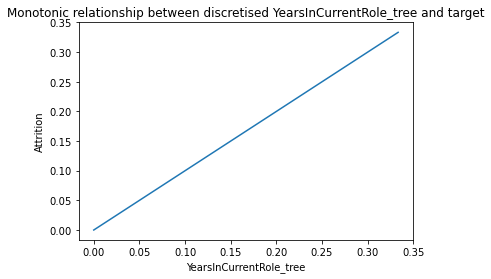

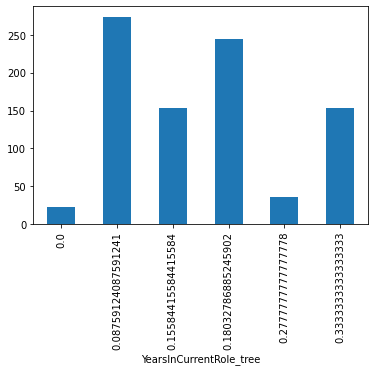

                         YearsInCurrentRole  YearsInCurrentRole
YearsInCurrentRole_tree                                        
0.000000                                  5                   5
0.087591                                  6                  16
0.155844                                  3                   4
0.180328                                  2                   2
0.277778                                  1                   1
0.333333                                  0                   0
{'0.0': {'left': 5, 'right': 5}, '0.08759124087591241': {'left': 6, 'right': 16}, '0.15584415584415584': {'left': 3, 'right': 4}, '0.18032786885245902': {'left': 2, 'right': 2}, '0.2777777777777778': {'left': 1, 'right': 1}, '0.3333333333333333': {'left': 0, 'right': 0}}


In [149]:
df_bin = variable_discretisation_insight("YearsInCurrentRole")
bins_mapping = {}
bins_list = list(df_bin.index)
for row, i in zip(df_bin.itertuples(), range(0, len(bins_list))):
    left = row.YearsInCurrentRole
    right = row._2
    bins_mapping[str(bins_list[i])] = {}
    bins_mapping[str(bins_list[i])]["left"] = left
    bins_mapping[str(bins_list[i])]["right"] = right
print(bins_mapping)
df_ts = discretize_test_set_variable("YearsInCurrentRole" , bins_mapping)

YearsInCurrentRole is a discretisation candidate

<h6> NumCompaniesWorked </h6>

NumCompaniesWorked's optimal_depth=3
[0.23529412 0.19174041 0.10824742 0.13157895 0.15492958 0.13924051
 0.34090909 0.26086957]


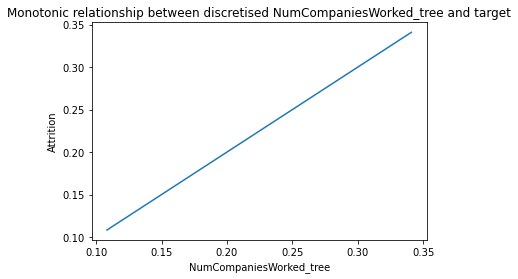

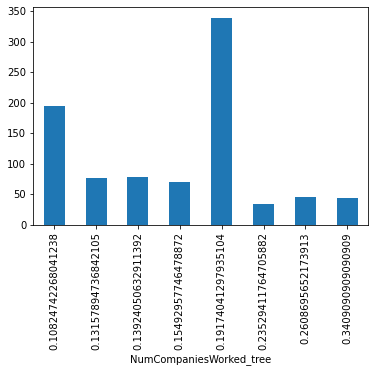

                         NumCompaniesWorked  NumCompaniesWorked
NumCompaniesWorked_tree                                        
0.108247                                  2                   3
0.131579                                  7                   8
0.139241                                  4                   4
0.154930                                  0                   0
0.191740                                  1                   1
0.235294                                  9                   9
0.260870                                  6                   6
0.340909                                  5                   5
{'0.10824742268041238': {'left': 2, 'right': 3}, '0.13157894736842105': {'left': 7, 'right': 8}, '0.13924050632911392': {'left': 4, 'right': 4}, '0.15492957746478872': {'left': 0, 'right': 0}, '0.19174041297935104': {'left': 1, 'right': 1}, '0.23529411764705882': {'left': 9, 'right': 9}, '0.2608695652173913': {'left': 6, 'right': 6}, '0.3409090909090909': {'

In [150]:
df_bin = variable_discretisation_insight("NumCompaniesWorked")
bins_mapping = {}
bins_list = list(df_bin.index)
for row, i in zip(df_bin.itertuples(), range(0, len(bins_list))):
    left = row.NumCompaniesWorked
    right = row._2
    bins_mapping[str(bins_list[i])] = {}
    bins_mapping[str(bins_list[i])]["left"] = left
    bins_mapping[str(bins_list[i])]["right"] = right
print(bins_mapping)
df_ts = discretize_test_set_variable("NumCompaniesWorked" , bins_mapping)

NumCompaniesWorked is a discretisation candidate

<h6> MonthlyIncome </h6>

MonthlyIncome's optimal_depth=3
[0.21333333 0.14373089 0.08988764 0.35849057 0.17910448 0.02564103
 0.14285714 1.        ]


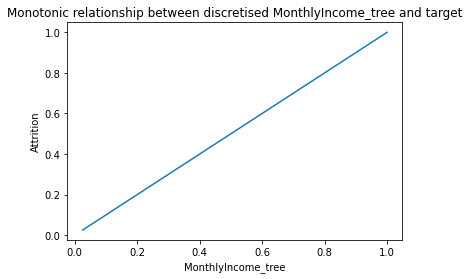

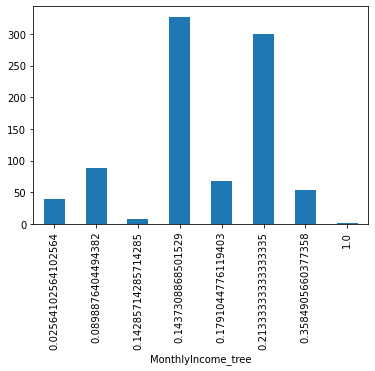

                    MonthlyIncome  MonthlyIncome
MonthlyIncome_tree                              
0.025641                     4148           4444
0.089888                    10496          16985
0.142857                     4465           4502
0.143731                     1009           4107
0.179104                    16998          26997
0.213333                     4510           9129
0.358491                     9150          10482
1.000000                     4127           4127
{'0.02564102564102564': {'left': 4148, 'right': 4444}, '0.0898876404494382': {'left': 10496, 'right': 16985}, '0.14285714285714285': {'left': 4465, 'right': 4502}, '0.1437308868501529': {'left': 1009, 'right': 4107}, '0.1791044776119403': {'left': 16998, 'right': 26997}, '0.21333333333333335': {'left': 4510, 'right': 9129}, '0.3584905660377358': {'left': 9150, 'right': 10482}, '1.0': {'left': 4127, 'right': 4127}}


In [151]:
df_bin = variable_discretisation_insight("MonthlyIncome")
bins_mapping = {}
bins_list = list(df_bin.index)
for row, i in zip(df_bin.itertuples(), range(0, len(bins_list))):
    left = row.MonthlyIncome
    right = row._2
    bins_mapping[str(bins_list[i])] = {}
    bins_mapping[str(bins_list[i])]["left"] = left
    bins_mapping[str(bins_list[i])]["right"] = right
print(bins_mapping)
df_ts = discretize_test_set_variable("MonthlyIncome" , bins_mapping)

MonthlyIncome is a discretisation candidate

<h6> MonthlyHours </h6>

In [152]:
to_drop_indexes = df_ts.index[df_ts["MonthlyHours"] > 590.9767441860465]
df_ts.drop(list(to_drop_indexes), axis=0, inplace=True)
df_ts.reset_index(drop=True, inplace=True)
print("dropped rows = ", len(to_drop_indexes), sep="\t")

df_ts.shape

dropped rows = 	0


(219, 37)

MonthlyHours's optimal_depth=1
[0.1723356 1.       ]


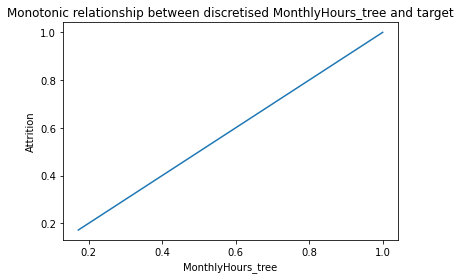

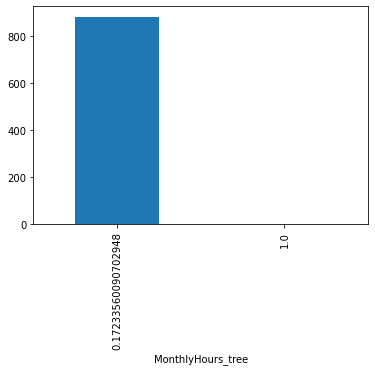

                   MonthlyHours  MonthlyHours
MonthlyHours_tree                            
0.172336              27.240964    590.976744
1.000000              26.043478     26.043478
{'0.17233560090702948': {'left': 27.24096385542169, 'right': 590.9767441860465}, '1.0': {'left': 26.04347826086957, 'right': 26.04347826086957}}


In [153]:
df_bin = variable_discretisation_insight("MonthlyHours")
bins_mapping = {}
bins_list = list(df_bin.index)
for row, i in zip(df_bin.itertuples(), range(0, len(bins_list))):
    left = row.MonthlyHours
    right = row._2
    bins_mapping[str(bins_list[i])] = {}
    bins_mapping[str(bins_list[i])]["left"] = left
    bins_mapping[str(bins_list[i])]["right"] = right
print(bins_mapping)
df_ts = discretize_test_set_variable("MonthlyHours" , bins_mapping)

MonthlyHours is NOT a discretisation candidate

<h6> PercentSalaryHike </h6>

PercentSalaryHike's optimal_depth=1
[0.18518519 0.12707182]


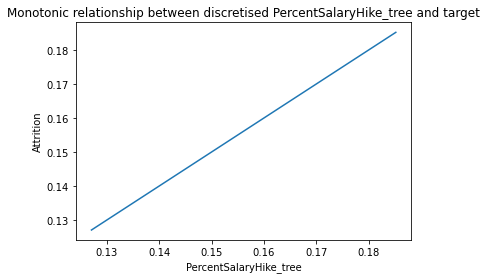

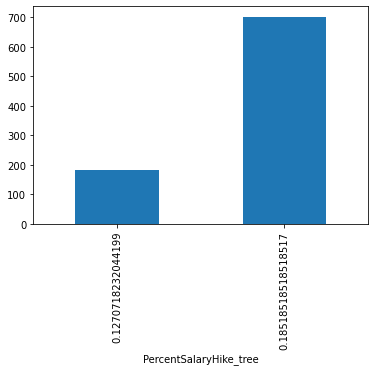

                        PercentSalaryHike  PercentSalaryHike
PercentSalaryHike_tree                                      
0.127072                               19                 25
0.185185                               11                 18
{'0.1270718232044199': {'left': 19, 'right': 25}, '0.18518518518518517': {'left': 11, 'right': 18}}


In [154]:
df_bin = variable_discretisation_insight("PercentSalaryHike")
bins_mapping = {}
bins_list = list(df_bin.index)
for row, i in zip(df_bin.itertuples(), range(0, len(bins_list))):
    left = row.PercentSalaryHike
    right = row._2
    bins_mapping[str(bins_list[i])] = {}
    bins_mapping[str(bins_list[i])]["left"] = left
    bins_mapping[str(bins_list[i])]["right"] = right
print(bins_mapping)
df_ts = discretize_test_set_variable("PercentSalaryHike" , bins_mapping)

PercentSalaryHike is a discretisation candidate

<h6> TaxRate </h6>

TaxRate's optimal_depth=3
[0.16409266 0.22959184 0.13380282 0.         1.        ]


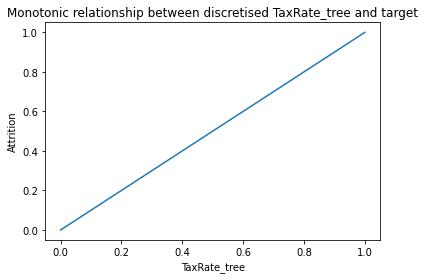

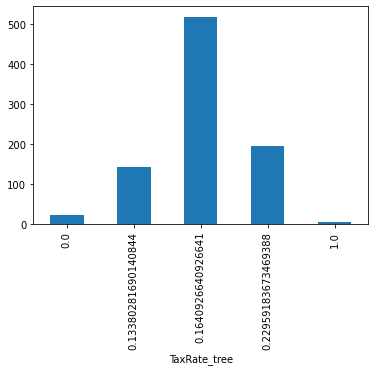

               TaxRate   TaxRate
TaxRate_tree                    
0.000000      0.799586  0.951396
0.133803      0.813039  0.915310
0.164093      0.000000  0.627428
0.229592      0.627641  0.795626
1.000000      0.797503  0.919407
{'0.0': {'left': 0.7995858856008973, 'right': 0.9513959334891722}, '0.13380281690140844': {'left': 0.8130389976677334, 'right': 0.9153100257984164}, '0.1640926640926641': {'left': 0.0, 'right': 0.6274281077242988}, '0.22959183673469388': {'left': 0.6276406210231611, 'right': 0.7956256722839727}, '1.0': {'left': 0.7975025312183598, 'right': 0.919407258376538}}


In [155]:
df_bin = variable_discretisation_insight("TaxRate")
bins_mapping = {}
bins_list = list(df_bin.index)
for row, i in zip(df_bin.itertuples(), range(0, len(bins_list))):
    left = row.TaxRate
    right = row._2
    bins_mapping[str(bins_list[i])] = {}
    bins_mapping[str(bins_list[i])]["left"] = left
    bins_mapping[str(bins_list[i])]["right"] = right
print(bins_mapping)
df_ts = discretize_test_set_variable("TaxRate" , bins_mapping)

TaxRate is a discretisation candidate

<h6> OverallSatisfaction </h6>

OverallSatisfaction's optimal_depth=3
[0.14864865 0.08391608 0.20472441 0.         0.32539683 1.
 0.5       ]


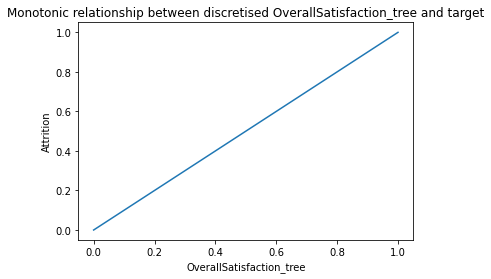

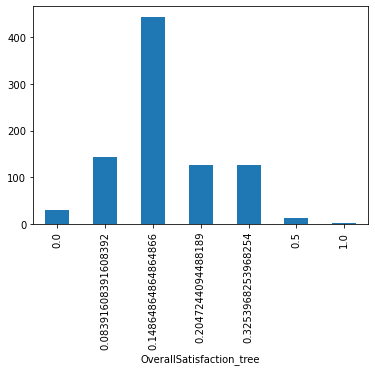

                          OverallSatisfaction  OverallSatisfaction
OverallSatisfaction_tree                                          
0.000000                                  3.6                  4.0
0.083916                                  3.2                  3.4
0.148649                                  2.6                  3.0
0.204724                                  2.4                  2.4
0.325397                                  1.8                  2.2
0.500000                                  1.4                  1.6
1.000000                                  1.2                  1.2
{'0.0': {'left': 3.6, 'right': 4.0}, '0.08391608391608392': {'left': 3.2, 'right': 3.4}, '0.14864864864864866': {'left': 2.6, 'right': 3.0}, '0.2047244094488189': {'left': 2.4, 'right': 2.4}, '0.3253968253968254': {'left': 1.8, 'right': 2.2}, '0.5': {'left': 1.4, 'right': 1.6}, '1.0': {'left': 1.2, 'right': 1.2}}


In [156]:
df_bin = variable_discretisation_insight("OverallSatisfaction")
bins_mapping = {}
bins_list = list(df_bin.index)
for row, i in zip(df_bin.itertuples(), range(0, len(bins_list))):
    left = row.OverallSatisfaction
    right = row._2
    bins_mapping[str(bins_list[i])] = {}
    bins_mapping[str(bins_list[i])]["left"] = left
    bins_mapping[str(bins_list[i])]["right"] = right
print(bins_mapping)
df_ts = discretize_test_set_variable("OverallSatisfaction" , bins_mapping)

TaxRate is a discretisation candidate

<h2> Discretize variables and save them on new file </h2>

In [157]:
def map_probabilities_to_increasing_integers(var_tree):
    values = sorted(list(X_train[var_tree].unique()))
    values_map = {}
    for i in range(1, len(values) + 1):
        values_map[str(values[i-1])] = i
    return values_map

In [158]:
def get_bin_indeces(var, X, train_or_test_flag):
    var_tree = "%s_tree" % var
    values_map = map_probabilities_to_increasing_integers(var_tree)
    bin_edges = [float(x) for x in list(values_map.keys())]
    bin_indeces = []
    if train_or_test_flag == "test":
        values = X[var]
    else:
        values = X[var_tree]
    for x in values:
        for edge in bin_edges:
            if x <= edge:
                bin_indeces.append(values_map[str(edge)])
                break
    return bin_indeces

In [159]:
def replace_categorical_feature_with_dummy_ones(column_name, categories_list, dummy_features, X):
    """
    Function which replaces the nominal feature passed by argument with dummy ones, 
    to convert nominal column's M values in M new binary (dummy) features.
    """
    # retrive nominal feature's index. It is used to know where to insert the new M binary features
    index = X.columns.get_loc(column_name)
    for i in range(0, dummy_features.shape[1]):
        index += 1
        X.insert(index, column_name + "_" + str(categories_list[i]), 
                                                              dummy_features[:, i].todense().astype(int), True)
    # remove categorical feature
    del X[column_name]
    return X

In [160]:
def perform_one_encoding(column_name, X):
    unique = list(X[column_name].unique())
    categories_list = sorted(unique)
    encoder = OneHotEncoder(categories=[categories_list])   # excplict force encoding order
    # fit and transform model on data
    dummy_features = encoder.fit_transform(X[column_name].values.reshape(-1,1))
    # add dummy features to dataset, replacing categorical feature
    return replace_categorical_feature_with_dummy_ones(column_name, categories_list, dummy_features, X)

In [161]:
discrete_variables = ["DistanceFromHome", "YearsAtCompany", "YearsInCurrentRole", "NumCompaniesWorked",
                      "MonthlyIncome", "PercentSalaryHike", "TaxRate", "Age", "MonthlyHours", 
                      "OverallSatisfaction"]
for var in discrete_variables:
    var_tree = "%s_tree" % var
    # print(var_tree, sorted(X_train[var_tree].unique()))
    bin_indeces = get_bin_indeces(var, X_train, "train")
    df_cleaned[var] = bin_indeces
    df_cleaned = perform_one_encoding(var, df_cleaned)
    bin_indeces = get_bin_indeces(var, df_ts, "test")
    df_ts[var] = bin_indeces
    df_ts = perform_one_encoding(var, df_ts)

In [162]:
discrete_variables = ["Education", "JobLevel", "EnvironmentSatisfaction", "JobInvolvement", "JobSatisfaction",
                      "RelationshipSatisfaction", "WorkLifeBalance", "StockOptionLevel", "TrainingTimesLastYear"]
for var in discrete_variables:
    df_cleaned = perform_one_encoding(var, df_cleaned)
    df_ts = perform_one_encoding(var, df_ts)

In [163]:
for x in df_cleaned.columns:
    if len(sorted(df_cleaned[x].unique())) > 2:
        print(x)

In [164]:
for x in df_ts.columns:
    if len(sorted(df_ts[x].unique())) > 2:
        print(x)

In [165]:
print(df_cleaned.shape)
print(df_ts.shape)

(883, 102)
(219, 98)


In [166]:
df1 = df_cleaned.copy()
df2 = df_ts.copy()

In [167]:
print(df1.shape)
print(df2.shape)

(883, 102)
(219, 98)


In [168]:
set(df1.columns).difference(set(df2.columns))

{'Age_2',
 'MonthlyHours_2',
 'MonthlyIncome_3',
 'OverallSatisfaction_7',
 'TaxRate_2'}

In [169]:
df1.to_csv(data_directory + "Discretized_One_Hot_Encoding_Train_HR_Employee_Attrition.csv", index=False, header=True)
df2.to_csv(data_directory + "Discretized_One_Hot_Encoding_Test_HR_Employee_Attrition.csv", index=False, header=True)

In [170]:
df_discretized = pd.read_csv(data_directory + "Discretized_One_Hot_Encoding_Train_HR_Employee_Attrition.csv", sep=",") 
df_discretized.shape

(883, 102)

In [171]:
df_discretized = pd.read_csv(data_directory + "Discretized_One_Hot_Encoding_Test_HR_Employee_Attrition.csv", sep=",") 
df_discretized.shape

(219, 98)